In [7]:
import pandas as pd
import numpy as np
import yfinance as yf
import openpyxl
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize

%config InlineBackend.figure_format = 'svg'

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

Pour chaque entreprise $i$, on définit la performance quotidienne par $r_t^i=\frac{P_t^i}{P_{t-1}^i}-1$. La performance quotidienne de notre indice américain : $r_t^{S \& P 300}=\sum_{i=1}^N \omega_t^ir_t^i$ avec $\boldsymbol{\omega}$ constant pendant le mois pour l'entreprise $i$ et dans notre cas $N=300$.

In [9]:
mapping = 'Mapping'
market_caps = 'MarketCaps'
sector = 'Sector'

In [10]:
mapping_df = pd.read_excel('DataProjets.xlsx', sheet_name=mapping, usecols=['Sedol', 'Tickers'])
tickers = mapping_df['Tickers'].tolist()

In [11]:
tickers

['AMZN',
 'AES',
 'IBM',
 'AMD',
 'ADBE',
 'APD',
 'BXP',
 'ALL',
 'HON',
 'AA',
 'AMGN',
 'HES',
 'AXP',
 'AEP',
 'AFL',
 'AIG',
 'ADI',
 'ALXN',
 'VLO',
 'APA',
 'CMCSA',
 'AAPL',
 'AMAT',
 'ADM',
 'PNW',
 'AEE',
 'ADSK',
 'ADP',
 'AZO',
 'BMC',
 'BKR',
 'BLL',
 'CEG',
 'BAX',
 'BBBY',
 'BDX',
 'AME',
 'VZ',
 'BBY',
 'YUM',
 'FE',
 'SLM',
 'HRB',
 'BA',
 'RHI',
 'BWA',
 'BSX',
 'CHRW',
 'BMY',
 'OKE',
 'AVB',
 'SRE',
 'FDX',
 'VRSN',
 'APH',
 'PWR',
 'CSX',
 'COG',
 'CPB',
 'STZ',
 'CAH',
 'CAT',
 'CTXS',
 'CHKAQ',
 'CERN',
 'JPM',
 'CHD',
 'CI',
 'CINF',
 'CTAS',
 'FTRCQ',
 'CSCO',
 'CLF',
 'CLX',
 'KO',
 'CL',
 'MAR',
 'AON',
 'CMA',
 'NRG',
 'CA',
 'DXC',
 'CAG',
 'ED',
 'GLW',
 'SEE',
 'DHI',
 'DHR',
 'MCO',
 'CTSH',
 'TGT',
 'DOFSQ',
 'DE',
 'MS',
 'RSG',
 'DIS',
 'DLTR',
 'RRD',
 'DD',
 'DTE',
 'CCI',
 'FLS',
 'DRI',
 'EBAY',
 'EMC',
 'BAC',
 'EP',
 'C',
 'EMN',
 'ETN',
 'DISH',
 'ECL',
 'EA',
 'CRM',
 'EMR',
 'ETR',
 'EOG',
 'EFX',
 'EQR',
 'EQT',
 'EL',
 'EXPD',
 'ESRX',
 'XO

In [12]:
start_date = '2015-01-01' 
end_date = '2023-12-31'
data_frames = {}

for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)['Adj Close']
    data.name = ticker
    data_frames[ticker] = data
all_data = pd.concat(data_frames.values(), axis=1, keys=data_frames.keys())

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [13]:
all_data.fillna(method='ffill', inplace=True)
all_data

/var/folders/b_/d4crx28d0235248h85260x280000gn/T/ipykernel_60533/1119645356.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_data.fillna(method='ffill', inplace=True)


,AMZN,AES,IBM,AMD,ADBE,APD,BXP,ALL,HON,AA,...,HPE,INFO,FTI,JHG,DOW,CTVA,AMCR,CARR,OTIS,VTRS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02 00:00:00,15.426000,9.979621,103.354828,2.670000,72.339996,108.431252,94.745506,57.149792,78.936684,36.321697,...,NaN,NaN,32.126144,NaN,NaN,NaN,7.637545,NaN,NaN,49.900417
2015-01-05 00:00:00,15.109500,9.695532,101.728569,2.660000,71.980003,104.964264,95.604469,56.016922,77.432434,34.217419,...,NaN,NaN,30.869282,NaN,NaN,NaN,7.637545,NaN,NaN,49.342518
2015-01-06 00:00:00,14.764500,9.476999,99.534668,2.630000,70.529999,104.926994,97.459534,55.976162,77.251312,34.469021,...,NaN,NaN,30.227032,NaN,NaN,NaN,7.637545,NaN,NaN,47.978790
2015-01-07 00:00:00,14.921000,9.491568,98.884132,2.580000,71.110001,106.060295,98.549492,56.897148,77.810471,35.361050,...,NaN,NaN,29.198055,NaN,NaN,NaN,7.310224,NaN,NaN,49.687881
2015-01-08 00:00:00,15.023000,9.637254,101.033386,2.610000,72.919998,108.513283,98.946487,57.989296,79.228081,36.367439,...,NaN,NaN,29.992233,NaN,NaN,NaN,7.310224,NaN,NaN,50.166084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22 00:00:00,153.419998,18.905285,160.675140,139.600006,598.750000,271.098877,69.901756,136.607574,204.515884,33.647999,...,16.965883,NaN,20.198778,29.715996,54.434303,47.320770,9.547615,57.099998,88.776443,10.546350
2023-12-26 00:00:00,153.410004,19.162636,161.735489,143.410004,598.260010,273.115906,71.075493,137.283661,206.902756,33.747639,...,17.104866,NaN,20.368433,29.854210,55.016964,47.859184,9.547615,57.439999,89.294495,10.605766
2023-12-27 00:00:00,153.339996,19.083450,161.983231,146.070007,596.080017,273.930695,70.750000,137.591858,207.877411,34.684242,...,16.965883,NaN,20.368433,30.071404,55.016964,47.839245,9.587068,57.779999,89.274567,10.665183


In [14]:
market_caps_df = pd.read_excel('DataProjets.xlsx', sheet_name=market_caps, index_col=0)
market_caps_df = market_caps_df.reindex(all_data.index, method='ffill')
weights_df = market_caps_df.divide(market_caps_df.sum(axis=1), axis=0)
weights_df.columns = tickers

returns_df = all_data.pct_change().fillna(method='ffill')
returns_df.fillna(0, inplace=True)
returns_df.columns = tickers

index_per_ticker = weights_df.mul(returns_df)
performance = index_per_ticker.sum(axis=1)

/var/folders/b_/d4crx28d0235248h85260x280000gn/T/ipykernel_60533/4214300513.py:6: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_df = all_data.pct_change().fillna(method='ffill')
/var/folders/b_/d4crx28d0235248h85260x280000gn/T/ipykernel_60533/4214300513.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  returns_df = all_data.pct_change().fillna(method='ffill')


In [15]:
returns_df

,AMZN,AES,IBM,AMD,ADBE,APD,BXP,ALL,HON,AA,...,HPE,INFO,FTI,JHG,DOW,CTVA,AMCR,CARR,OTIS,VTRS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-01-05 00:00:00,-0.020517,-0.028467,-0.015735,-0.003745,-0.004976,-0.031974,0.009066,-0.019823,-0.019056,-0.057934,...,0.000000,0.0,-0.039123,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.011180
2015-01-06 00:00:00,-0.022833,-0.022540,-0.021566,-0.011278,-0.020145,-0.000355,0.019404,-0.000728,-0.002339,0.007353,...,0.000000,0.0,-0.020805,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.027638
2015-01-07 00:00:00,0.010600,0.001537,-0.006536,-0.019011,0.008223,0.010801,0.011184,0.016453,0.007238,0.025879,...,0.000000,0.0,-0.034042,0.000000,0.000000,0.000000,-0.042857,0.000000,0.000000,0.035622
2015-01-08 00:00:00,0.006836,0.015349,0.021735,0.011628,0.025453,0.023128,0.004028,0.019195,0.018219,0.028460,...,0.000000,0.0,0.027200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22 00:00:00,-0.002730,0.013263,0.008459,-0.002216,-0.002316,0.004048,-0.005333,0.014771,0.002877,0.054653,...,0.005294,0.0,0.011494,0.001331,0.002729,0.003595,-0.003090,0.003162,0.008032,0.000000
2023-12-26 00:00:00,-0.000065,0.013613,0.006599,0.027292,-0.000818,0.007440,0.016791,0.004949,0.011671,0.002961,...,0.008192,0.0,0.008399,0.004651,0.010704,0.011378,0.000000,0.005954,0.005835,0.005634
2023-12-27 00:00:00,-0.000456,-0.004132,0.001532,0.018548,-0.003644,0.002983,-0.004580,0.002245,0.004711,0.027753,...,-0.008125,0.0,0.000000,0.007275,0.000000,-0.000417,0.004132,0.005919,-0.000223,0.005602


In [16]:
returns_df.index = pd.to_datetime(returns_df.index)

monthly_returns_df = returns_df.resample('ME').mean()
variances = monthly_returns_df.var()
covariance_matrix = monthly_returns_df.cov()

In [17]:
def covariance_per_month(returns_df):
    grouped = returns_df.groupby([returns_df.index.year, returns_df.index.month])
    monthly_covariances = {}
    for (year, month), group in grouped:
        # Calculate covariance matrix for this group
        cov_matrix = group.cov()
        monthly_covariances[(year, month)] = cov_matrix
    
    return monthly_covariances

In [18]:
extract_variances = lambda x : x.var()
monthly_variances = returns_df.groupby([returns_df.index.year, returns_df.index.month]).apply(extract_variances)
monthly_variances

AMZN       AES       IBM       AMD      ADBE       APD  \
Date Date                                                               
2015 1     0.001247  0.000254  0.000241  0.001295  0.000239  0.000348   
     2     0.000154  0.000462  0.000100  0.001989  0.000078  0.000067   
     3     0.000137  0.000324  0.000191  0.000435  0.000215  0.000104   
     4     0.001148  0.000210  0.000168  0.001081  0.000105  0.000197   
     5     0.000107  0.000167  0.000066  0.000239  0.000118  0.000102   
...             ...       ...       ...       ...       ...       ...   
2023 8     0.000520  0.000407  0.000046  0.000995  0.000322  0.000218   
     9     0.000408  0.000445  0.000102  0.000546  0.000314  0.000137   
     10    0.000701  0.000766  0.000182  0.000612  0.000372  0.000160   
     11    0.000175  0.000975  0.000045  0.000728  0.000233  0.000949   
     12    0.000143  0.000586  0.000042  0.000773  0.000357  0.000099   

                BXP       ALL       HON        AA  ...       HPE  INFO  \
Date Date                                          ...                   
2015 1     0.000122  0.000172  0.000177  0.000594  ...  0.000000   0.0   
     2     0.000168  0.000099  0.000076  0.000679  ...  0.000000   0.0   
     3     0.000221  0.000102  0.000177  0.000353  ...  0.000000   0.0   
     4     0.000099  0.000043  0.000074  0.000177  ...  0.000000   0.0   
     5     0.000145  0.000110  0.000088  0.000246  ...  0.000000   0.0   
...             ...       ...       ...       ...  ...       ...   ...   
2023 8     0.000372  0.000488  0.000048  0.000411  ...  0.000201   0.0   
     9     0.000520  0.000220  0.000105  0.001420  ...  0.000365   0.0   
     10    0.000613  0.000336  0.000156  0.001165  ...  0.000403   0.0   
     11    0.001252  0.000079  0.000063  0.000575  ...  0.000437   0.0   
     12    0.001396  0.000150  0.000084  0.002506  ...  0.000234   0.0   

                FTI       JHG       DOW      CTVA      AMCR      CARR  \
Date Date                                                               
2015 1     0.000593  0.000000  0.000000  0.000000  0.000317  0.000000   
     2     0.000595  0.000000  0.000000  0.000000  0.000034  0.000000   
     3     0.000202  0.000000  0.000000  0.000000  0.000154  0.000000   
     4     0.000855  0.000000  0.000000  0.000000  0.000000  0.000000   
     5     0.000239  0.000000  0.000000  0.000000  0.000024  0.000000   
...             ...       ...       ...       ...       ...       ...   
2023 8     0.000186  0.000279  0.000135  0.000148  0.000134  0.000243   
     9     0.000424  0.000181  0.000185  0.000149  0.000259  0.000388   
     10    0.000665  0.000358  0.000175  0.000179  0.000201  0.000367   
     11    0.000482  0.000297  0.000148  0.000629  0.000188  0.000237   
     12    0.000436  0.000134  0.000166  0.000254  0.000142  0.000364   

               OTIS      VTRS  
Date Date                      
2015 1     0.000000  0.000620  
     2     0.000000  0.000207  
     3     0.000000  0.000798  
     4     0.000000  0.001987  
     5     0.000000  0.000168  
...             ...       ...  
2023 8     0.000089  0.000210  
     9     0.000095  0.000221  
     10    0.000108  0.000275  
     11    0.000101  0.000309  
     12    0.000072  0.000182  

[108 rows x 561 columns]

In [19]:
monthly_returns_df = returns_df.resample('ME').mean()
monthly_returns_df

,AMZN,AES,IBM,AMD,ADBE,APD,BXP,ALL,HON,AA,...,HPE,INFO,FTI,JHG,DOW,CTVA,AMCR,CARR,OTIS,VTRS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-31,0.007531,-0.005177,-0.002657,-0.001302,-0.001437,0.000224,0.002855,-0.000154,-0.001163,-0.000442,...,0.000000,0.0,-0.010462,0.000000,0.000000,0.000000,-0.006346,0.000000,0.000000,-0.002629
2015-02-28,0.003753,0.003358,0.003303,0.010983,0.006392,0.003713,-0.000450,0.000877,0.002937,-0.002551,...,0.000000,0.0,0.003616,0.000000,0.000000,0.000000,0.002169,0.000000,0.000000,0.004090
2015-03-31,-0.000908,-0.000268,-0.000314,-0.006531,-0.002958,-0.001145,0.001322,0.000414,0.000756,-0.005954,...,0.000000,0.0,-0.003349,0.000000,0.000000,0.000000,0.001686,0.000000,0.000000,0.001952
2015-04-30,0.006495,0.001560,0.003183,-0.007555,0.001397,-0.002438,-0.002802,-0.001000,-0.001537,0.001895,...,0.000000,0.0,0.008783,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010318
2015-05-31,0.000926,0.001763,-0.000073,0.000555,0.002011,0.001196,-0.000800,-0.001431,0.001886,-0.003321,...,0.000000,0.0,-0.002573,0.000000,0.000000,0.000000,0.000012,0.000000,0.000000,0.000335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,0.001629,-0.007926,0.001312,-0.002942,0.001191,-0.001316,0.000269,-0.001322,-0.001148,-0.007683,...,-0.000891,0.0,0.001839,-0.002106,-0.000876,-0.004601,-0.002195,-0.001443,-0.002447,0.001470
2023-09-30,-0.003906,-0.008010,-0.002224,-0.001130,-0.004465,-0.001716,-0.004677,0.001748,-0.000808,-0.001049,...,0.001630,0.0,0.003510,-0.003005,-0.002736,0.000709,-0.002291,-0.001811,-0.003110,-0.004205
2023-10-31,0.002422,-0.000027,0.001471,-0.001656,0.002113,-0.000077,-0.004451,0.006534,-0.000291,-0.004924,...,-0.005320,0.0,0.002873,-0.004932,-0.002843,-0.002676,-0.001263,-0.006298,-0.001736,-0.004513


In [20]:
monthly_covariance_matrices = returns_df.groupby([returns_df.index.year, returns_df.index.month]).apply(covariance_per_month)

In [21]:
covariance_matrix

,AMZN,AES,IBM,AMD,ADBE,APD,BXP,ALL,HON,AA,...,HPE,INFO,FTI,JHG,DOW,CTVA,AMCR,CARR,OTIS,VTRS
AMZN,0.000018,0.000005,0.000004,0.000017,0.000010,0.000003,0.000006,1.342335e-06,0.000004,0.000008,...,0.000004,0.0,5.095816e-06,0.000005,0.000003,0.000002,0.000002,0.000005,0.000002,0.000005
AES,0.000005,0.000016,0.000004,0.000007,0.000006,0.000005,0.000006,4.051330e-06,0.000006,0.000012,...,0.000006,0.0,8.631506e-06,0.000006,0.000005,0.000004,0.000004,0.000003,0.000002,0.000007
IBM,0.000004,0.000004,0.000010,0.000009,0.000005,0.000004,0.000005,4.228947e-06,0.000005,0.000010,...,0.000006,0.0,8.382382e-06,0.000005,0.000004,0.000002,0.000005,0.000001,0.000002,0.000009
AMD,0.000017,0.000007,0.000009,0.000061,0.000014,0.000007,0.000009,1.214654e-06,0.000009,0.000017,...,0.000010,0.0,1.046950e-05,0.000008,0.000005,0.000003,0.000008,0.000008,0.000004,0.000010
ADBE,0.000010,0.000006,0.000005,0.000014,0.000015,0.000005,0.000004,1.230535e-06,0.000006,0.000008,...,0.000006,0.0,4.470828e-06,0.000007,0.000005,0.000002,0.000005,0.000005,0.000004,0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CTVA,0.000002,0.000004,0.000002,0.000003,0.000002,0.000002,0.000004,1.550820e-06,0.000003,0.000011,...,0.000004,0.0,7.503264e-06,0.000004,0.000005,0.000006,0.000003,0.000002,0.000002,0.000004
AMCR,0.000002,0.000004,0.000005,0.000008,0.000005,0.000004,0.000004,2.706182e-06,0.000005,0.000010,...,0.000005,0.0,5.419672e-06,0.000006,0.000005,0.000003,0.000009,0.000003,0.000002,0.000005
CARR,0.000005,0.000003,0.000001,0.000008,0.000005,0.000003,0.000002,-1.514595e-07,0.000002,0.000005,...,0.000003,0.0,-6.574701e-07,0.000005,0.000003,0.000002,0.000003,0.000012,0.000005,0.000003
OTIS,0.000002,0.000002,0.000002,0.000004,0.000004,0.000002,0.000002,8.692941e-07,0.000003,0.000005,...,0.000003,0.0,1.154328e-06,0.000003,0.000003,0.000002,0.000002,0.000005,0.000004,0.000003


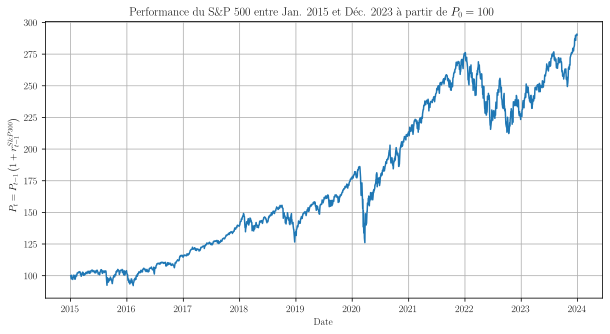

In [27]:
index_values = pd.Series(index=performance.index)
# Définissez la valeur initiale de l'indice
P_0 = 100
index_values.iloc[0] = P_0
for i in range(1, len(index_values)):
    index_values.iloc[i] = index_values.iloc[i - 1] * (1 + performance.iloc[i])

plt.figure(figsize=(10, 5))
plt.plot(index_values)
plt.title('Performance du S\&P 500 entre Jan. 2015 et Déc. 2023 à partir de $P_0 = 100$')
plt.xlabel('Date')
plt.ylabel('$P_t = P_{t-1} \left(1+r_{t-1}^{S\& P300}\\right)$')
plt.grid(True)
plt.show()

**Key risk indicators**
- Performance
- Volatilité annualisée
- Maximum drawdown
- VaR à $\alpha = 0.05$

In [23]:
global_performance = (index_values[-1]/index_values[0])-1

cumulative_returns = (1 + performance).cumprod()
running_max = cumulative_returns.cummax()
drawdown = (cumulative_returns/running_max)-1
max_drawdown = drawdown.min()

mean_returns = performance.mean()
daily_std = performance.std()

annualized_volatility = daily_std * np.sqrt(252)

VaR_95 = norm.ppf(0.05, mean_returns, daily_std)

print(f"VaR à 95% (en termes de perte) : {VaR_95}")
print(f"Annualized Volatility: {annualized_volatility}")
print(f"Global Performance: {global_performance}")
print(f"Maximum Drawdown: {max_drawdown}")

VaR à 95% (en termes de perte) : -0.017945968728421538
Annualized Volatility: 0.17834924839416272
Global Performance: 1.900999534892482
Maximum Drawdown: -0.32270500135196833


/var/folders/b_/d4crx28d0235248h85260x280000gn/T/ipykernel_60533/449629738.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  global_performance = (index_values[-1]/index_values[0])-1


**Sectors.**
For a sector $S$, we define the $\beta$ and the tracking error by
- $\beta_S = \frac{\mathrm{cov}(r^S,r^{S\& P300})}{\mathbf V(r^{S\& P300})}$
- $\sigma^S_{\textrm{tracking error}} = \sqrt{\frac{1}{N}\sum_{t=1}^N\left (r^S_t -r^{S\& P300}_t\right )^2}$

Maximizing the expected return of the portfolio under a volatility constraint: $\max_{\boldsymbol{\omega}} \boldsymbol \mu^\top\boldsymbol{\omega} \ \mathrm{s.t.} \ \boldsymbol{\omega}^\top  \Sigma \boldsymbol{\omega} \leqslant {\sigma^*}^2$ or $\min_{\boldsymbol{\omega}} \boldsymbol{\omega}^\top  \Sigma \boldsymbol{\omega} \ \mathrm{s.t.} \ \boldsymbol \mu^\top\boldsymbol{\omega} \geqslant \mu^*$.

**Lagrange multiplier:** Define $\displaystyle\mathcal L(\boldsymbol{\omega}, \lambda)= \frac{1}{2}\boldsymbol{\omega}^\top  \Sigma \boldsymbol{\omega}+ \lambda( \mu^\top\boldsymbol{\omega} - \mu^*)$. Then $\nabla_{\boldsymbol{\omega}, \lambda}\mathcal L(\boldsymbol{\omega}, \lambda)=0$ yields $$\widehat{\boldsymbol{\omega}} = \mu^* \frac{\Sigma^{-1}\boldsymbol\mu}{\boldsymbol{\mu} \Sigma^{-1}\boldsymbol{\mu}}.$$
One could similarly look for $\displaystyle\widehat{\boldsymbol{\omega}} = \argmax_{\boldsymbol{\omega}} \left( \boldsymbol \mu^\top\boldsymbol{\omega} - \frac{\lambda}{2}\boldsymbol{\omega}^\top \Sigma \boldsymbol{\omega}\right)$, where $\lambda$ is the risk aversion parameter.

We set $\rho$ as the correlation matrix, $\sigma$ the vector of standard deviation, $\Sigma=\operatorname{diag}(\boldsymbol{\sigma})\rho\operatorname{diag}(\boldsymbol{\sigma})$ the covariance matrix and $\boldsymbol{\mu}$ as the vector of expected returns. For Mean-Variance Optimization, we are looking to maximize the expected return of the portfolio under a volatility constraint. Here we take $\sigma^* = 10\%$.

In [24]:
# Define the expected returns vector
mu = np.array([5.7, 6.6, 3.3, 1.6, 0.2])/100  # Convert to decimal

# Define the standard deviation vector
sigma = np.array([14.3, 16.4, 8.3, 4.0, 0.5])

# Define the correlation matrix
rho = np.array([
    [1.0, 0.821, -0.05, 0.25, 0],
    [0.821, 1.0, -0.14, 0.10, 0],
    [-0.05, -0.14, 1.0, 0.67, 0],
    [0.25, 0.10, 0.67, 1.0, 0],
    [0, 0, 0, 0, 1.0]
])

# Construct the covariance matrix
Sigma = np.diag(sigma) @ rho @ np.diag(sigma)/10000  # Convert to decimal

# Define the number of assets
n_assets = len(mu)

# Define the objective function (negative expected return)
def objective_function(weights, expected_returns):
    return -np.dot(weights, expected_returns)

# All weights should sum up to 1 (fully invested portfolio)
constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]

# Portfolio variance should be less than 10%
risk_limit = 0.10**2
def risk_constraint(weights):
    return risk_limit - weights.T @ Sigma @ weights

constraints.append({'type': 'ineq', 'fun': risk_constraint})

# Define the bounds for weights (no short selling)
bounds = tuple((0, 1) for asset in range(n_assets))

# Initial guess for the weights (equally weighted portfolio)
initial_weights = np.array(n_assets * [1.0 / n_assets])

# Solve the optimization problem
result = minimize(objective_function, initial_weights, args=(mu,), bounds=bounds, constraints=constraints)

# The optimal weights for the portfolio
w_opt = result.x
w_opt, n_assets

(array([2.87553417e-01, 3.81859112e-01, 3.30587471e-01, 6.71121145e-17,
        0.00000000e+00]),
 5)

Now, we look for $\displaystyle\widehat{\boldsymbol{\omega}} = \argmax_{\boldsymbol{\omega}} \left( \boldsymbol \mu^\top\boldsymbol{\omega} - \lambda\boldsymbol{\omega}^\top \Sigma \boldsymbol{\omega}\right)$, where $\lambda$ is the risk aversion parameter. Let's compute $\nabla_{\boldsymbol{\omega}}\left (\boldsymbol \mu^\top\boldsymbol{\omega} - \lambda\boldsymbol{\omega}^\top \Sigma \boldsymbol{\omega}\right)$. Setting this to zero, this yields $$\widehat{\boldsymbol{\omega}} = \frac{\mathbf \Sigma^{-1}\boldsymbol \mu}{2\lambda}$$.

In [25]:
# Compute mu^T * Sigma^-1 * mu
mu_T_Sigma_inv_mu = mu.T @ np.linalg.inv(Sigma) @ mu

# Compute the analytical lambda value
lambda_analytical = 0.5 * np.sqrt(mu_T_Sigma_inv_mu / risk_limit)
lambda_analytical

3.668777098867541

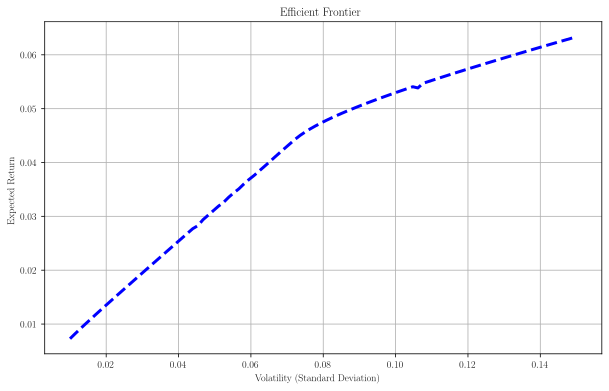

In [26]:
# Define the range of target risks (volatilities)
target_risks = np.linspace(0.01, 0.15, 100)

# Initialize lists to store the results
efficient_frontier_returns = []
efficient_frontier_risks = []

# Optimization for each target risk
for target_risk in target_risks:
    # Define the constraints for this target risk
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                   {'type': 'ineq', 'fun': lambda x: target_risk**2 - x.T @ Sigma @ x}]
    
    # Perform the optimization
    result = minimize(objective_function, initial_weights, args=(mu,),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    
    if result.success:
        # Store the expected return and the target risk if the optimization was successful
        efficient_frontier_returns.append(-result.fun)
        efficient_frontier_risks.append(target_risk)

# Plot the efficient frontier
plt.figure(figsize=(10, 6))
plt.plot(efficient_frontier_risks, efficient_frontier_returns, 'b--', linewidth=3)
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.grid(True)
plt.show()
